<h2>MMP Core/r-groups combination using CGR</h2>
<p>This notebook contains methods to extract the molecular graph information and connect MMP core and fragments using condensed graph of reaction approach.<p>
    <em>Coded by: Javed Iqbal: 16.02.2021, last update: 13.12.2021<br>b-it(Bonn-Aachen International Center for Information Technology)</em>
    
 

In [1]:
def connect_fragments(NF, AF, R1Atom=85):
    import numpy as np
    #Lookup for R1Atom 
    items=np.where(NF==R1Atom)[0]
    for item in items:
        #Remove R1 Edges
        AF[:,item]=0
        AF[item,:]=0
        #Remove R1 Node
        NF[item]=0
        #Add New edges between Core, Frag1, frag2 R1 sites
       
        AF[items[0]+1,item+1]=1
        AF[item+1,items[0]+1]=1
        
    return NF, AF
def getBonds(mol):
    #This method get bond information between atoms.
    shape=(mol.GetNumAtoms(),mol.GetNumAtoms())
    bonds=np.zeros((shape),dtype="float")
    for i in range(mol.GetNumAtoms()):
        for j in range(mol.GetNumAtoms()):
            if mol.GetBondBetweenAtoms(i,j) is not None:
                bonds[i,j]=mol.GetBondBetweenAtoms(i,j).GetBondTypeAsDouble() #Get the bond type
    return bonds
def joinAdjacency(a, b):
    import numpy as np
    #Append the array a and b in diagonal direction
    Zeros=np.zeros((a.shape[0], b.shape[1]), dtype="int")
    out1=np.append(a,Zeros, axis=1)
    out2=np.append( Zeros.T,b, axis=1)
    combined=np.concatenate((out1,out2), axis=0)
    return combined
def getExplicitHs(mol):
    return np.array([iAtom.GetNumExplicitHs() for iAtom in mol.GetAtoms()])
def getCharges(mol):
    return np.array([iAtom.GetFormalCharge() for iAtom in mol.GetAtoms()])

def MolFromGraphs( node_list, adjacency_matrix, explicitHs, charges):
    removeAtoms=set()
    cleanupAtoms=set()
    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    for i in range(len(node_list)):
        if(node_list[i])==0:
            continue
        a = Chem.Atom(int(node_list[i]))

        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx
        
    # add bonds between adjacent atoms
    for ix, row in enumerate(adjacency_matrix):
        for iy, bond in enumerate(row):
            
            # only traverse half the matrix
            if (iy <= ix) or (ix in removeAtoms) or (iy in removeAtoms):
                continue

            # add relevant bond type (there are many more of these)
            if bond == 0:
                continue
            elif bond == 1:
               
               
                bond_type = Chem.rdchem.BondType.SINGLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 2:
               
                bond_type = Chem.rdchem.BondType.DOUBLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 1.5:
                bond_type= Chem.rdchem.BondType.AROMATIC
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond ==3:
                bond_type=Chem.rdchem.BondType.TRIPLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            else:
                print("error: unknown bond type")
   

    #One r_group is connected with single bond and second is presented with a ZERO bond  

    #Working with r_groups having only single Atoms
    if(len([nb.GetBondTypeAsDouble() for nb in  mol.GetAtomWithIdx(0).GetBonds() if nb.GetBondTypeAsDouble()==1])==1):

        for nb in sorted([nb.GetIdx() for nb in mol.GetAtomWithIdx(0).GetNeighbors()], reverse=True):
            if(mol.GetBondBetweenAtoms(0,nb).GetBondTypeAsDouble()==1):
                mol.GetBondBetweenAtoms(0,nb).SetBondType(Chem.rdchem.BondType.ZERO)
    else:
    #Working with r_groups having multiple Atoms    
        for nb in sorted([nb.GetIdx() for nb in mol.GetAtomWithIdx(0).GetNeighbors()], reverse=True):


            if(mol.GetBondBetweenAtoms(0,nb).GetBondTypeAsDouble()==1):

                mol.GetBondBetweenAtoms(0,nb).SetBondType(Chem.rdchem.BondType.ZERO)
                break
    #Transfer Atomic Charges
    for ix in np.where(charges)[0]:
        mol.GetAtomWithIdx(node_to_idx[ix]).SetFormalCharge(int(charges[ix]))
    #Transfer explicit Hydrogens
    for ix in np.where(explicitHs)[0]:
        mol.GetAtomWithIdx(node_to_idx[ix]).SetNumExplicitHs(int(explicitHs[ix]))
               
    # Convert RWMol to Mol object
    mol = mol.GetMol()
    
    return mol

In [2]:
#importing libraries
from rdkit import Chem
import numpy as np
from rdkit.Chem import Draw

In [3]:
#Defining example Data
core='[R1]C(=O)CSc1ccccc1c2ccc(c(c2)F)c3cnc(cn3)N'
r_group1='[R1]N'
r_group2='[R1]N(CC)CC'
original_cpd1='c1ccc(c(c1)c2ccc(c(c2)F)c3cnc(cn3)N)SCC(=O)N'
original_cpd2='CCN(CC)C(=O)CSc1ccccc1c2ccc(c(c2)F)c3cnc(cn3)N'
#R1 sites are replaced with At (Astatine)
R1Site="At"
R1AtomicNum=Chem.RWMol(Chem.MolFromSmiles("[At]")).GetAtoms()[0].GetAtomicNum()
#Reading the Core as Molecule
coreMol=Chem.MolFromSmiles(core.replace("R1", R1Site))
#Get Core Bond information
core_adj=getBonds(coreMol)
#Get Atomic numbers of core
coreAtoms=np.array([atom.GetAtomicNum() for atom in Chem.RWMol(coreMol).GetAtoms()])

#Reading r-groups  as Molecule
r_group1_Mol=Chem.MolFromSmiles(r_group1.replace("R1", R1Site))
r_group2_Mol=Chem.MolFromSmiles(r_group2.replace("R1", R1Site))

#Get r_group Bond information
r_group1_adj=getBonds(r_group1_Mol)
r_group2_adj=getBonds(r_group2_Mol)

#Get r_group Atom information
r_group1_Atoms=np.array([atom.GetAtomicNum() for atom in Chem.RWMol(r_group1_Mol).GetAtoms()])
r_group2_Atoms=np.array([atom.GetAtomicNum() for atom in Chem.RWMol(r_group2_Mol).GetAtoms()])

#Concatenate the core and fragment atoms
AtomFeatures=np.concatenate([coreAtoms,r_group1_Atoms,r_group2_Atoms])

#combine the core and r_group graphs
AtomFeatures,newAdjacency=connect_fragments(AtomFeatures, joinAdjacency(joinAdjacency(core_adj, r_group1_adj), r_group2_adj), R1Atom=R1AtomicNum)

#extract the Explicit Hydrogens and charges

CoreexplictHs=getExplicitHs(coreMol)
r_group1_Hs=getExplicitHs(r_group1_Mol)
r_group2_Hs=getExplicitHs(r_group2_Mol)
explicitHs=np.concatenate([CoreexplictHs, r_group1_Hs, r_group2_Hs])

CoreCharges=getCharges(coreMol)
r_group1_charges=getCharges(r_group1_Mol)
r_group2_charges=getCharges(r_group2_Mol)
charges=np.concatenate([CoreCharges, r_group1_charges, r_group2_charges])


In [4]:
#Convert the Graph data into rdkit Molecule 
newmol=MolFromGraphs(AtomFeatures, newAdjacency, explicitHs, charges)


In [7]:
new_smiles=Chem.MolToSmiles(newmol)
print("Cpd1_Smiles:%s"%original_cpd1)
print("Cpd2_Smiles:%s"%original_cpd2)
print("CGR_Smiles:%s"%new_smiles)

Cpd1_Smiles:c1ccc(c(c1)c2ccc(c(c2)F)c3cnc(cn3)N)SCC(=O)N
Cpd2_Smiles:CCN(CC)C(=O)CSc1ccccc1c2ccc(c(c2)F)c3cnc(cn3)N
CGR_Smiles:CCN(CC)~C(N)(=O)CSc1ccccc1-c1ccc(-c2cnc(N)cn2)c(F)c1


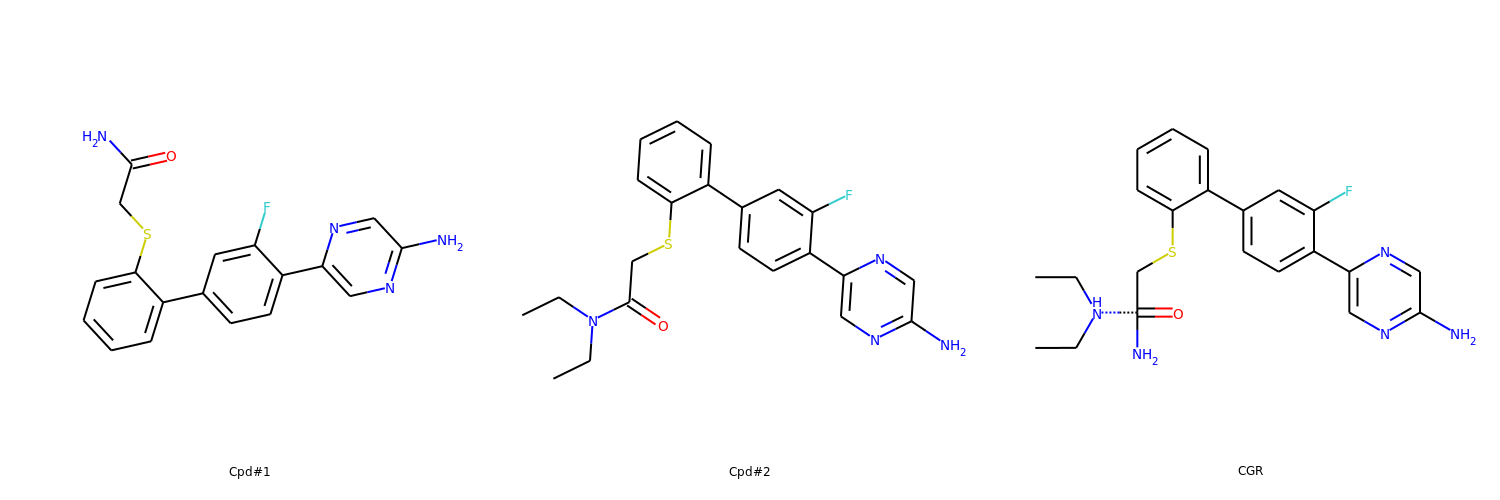

In [8]:

#colsPerRow=3, legends=scores, subImgSize=(250,250)
Draw.MolsToGridImage([Chem.MolFromSmiles(original_cpd1), Chem.MolFromSmiles(original_cpd2), newmol],molsPerRow=3,subImgSize=(500,500), legends=["Cpd#1","Cpd#2", "CGR"])